In [23]:
# load Kohonen package
require(kohonen)

In [24]:
# slightly reduce plotsize
options(repr.plot.width=7, repr.plot.height=7)

In [32]:
# load my own plotting functions:
source("Kohonen/som_visualization_r/somComponentPlanePlottingFunction.R")
source("Kohonen/som_visualization_r/plotUMatrix.R")
source("Kohonen/som_visualization_r/addClusterBoundaries.R")
source("Kohonen/som_visualization_r/addText.R")

In [1]:
data(iris)
str(iris)

'data.frame':	150 obs. of  5 variables:
 $ Sepal.Length: num  5.1 4.9 4.7 4.6 5 5.4 4.6 5 4.4 4.9 ...
 $ Sepal.Width : num  3.5 3 3.2 3.1 3.6 3.9 3.4 3.4 2.9 3.1 ...
 $ Petal.Length: num  1.4 1.4 1.3 1.5 1.4 1.7 1.4 1.5 1.4 1.5 ...
 $ Petal.Width : num  0.2 0.2 0.2 0.2 0.2 0.4 0.3 0.2 0.2 0.1 ...
 $ Species     : Factor w/ 3 levels "setosa","versicolor",..: 1 1 1 1 1 1 1 1 1 1 ...


In [2]:
# create SOM data
colnames(iris)[1:4]
somdata = scale(iris[colnames(iris)[1:4]])

[1] "Sepal.Length" "Sepal.Width"  "Petal.Length" "Petal.Width"

In [49]:
# train SOM
data.som1 <- som(somdata,
                 rlen=1000, # the number of times the complete data set will be presented to the network
                 alpha = c(0.05, 0.01), # default = c(0.05, 0.01)
                 grid = somgrid(10, 10, "hexagonal", toroidal = FALSE) # "hexagonal" or "rectangular"
                ) 

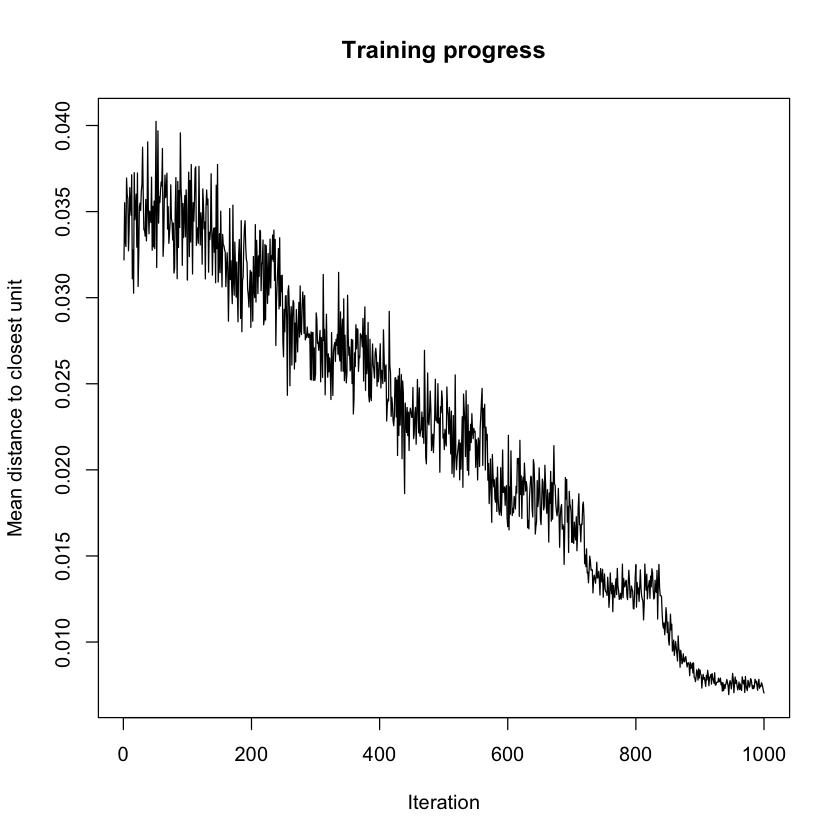

In [50]:
# plot training process: # only after 500 views, a kind of plateau is visible!
plot(data.som1, type="changes")

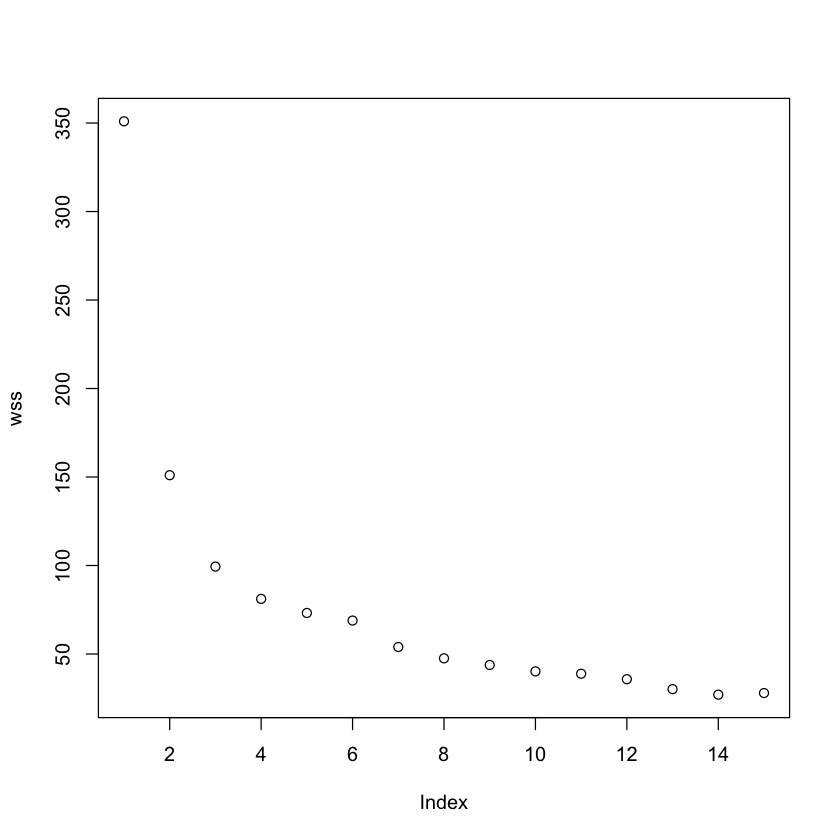

In [46]:
# clustering:
# Viewing WCSS for kmeans (WCSS=Within-Cluster-Sum-of-Squares)
mydata <- data.som1$codes[[1]]
wss <- (nrow(mydata)-1)*sum(apply(mydata,2,var))
for (i in 2:15) {
  wss[i] <- sum(kmeans(mydata, centers=i)$withinss)
}
plot(wss)

som_cluster <- cutree(hclust(dist(data.som1$codes[[1]])), 3) # assuming three clusters!

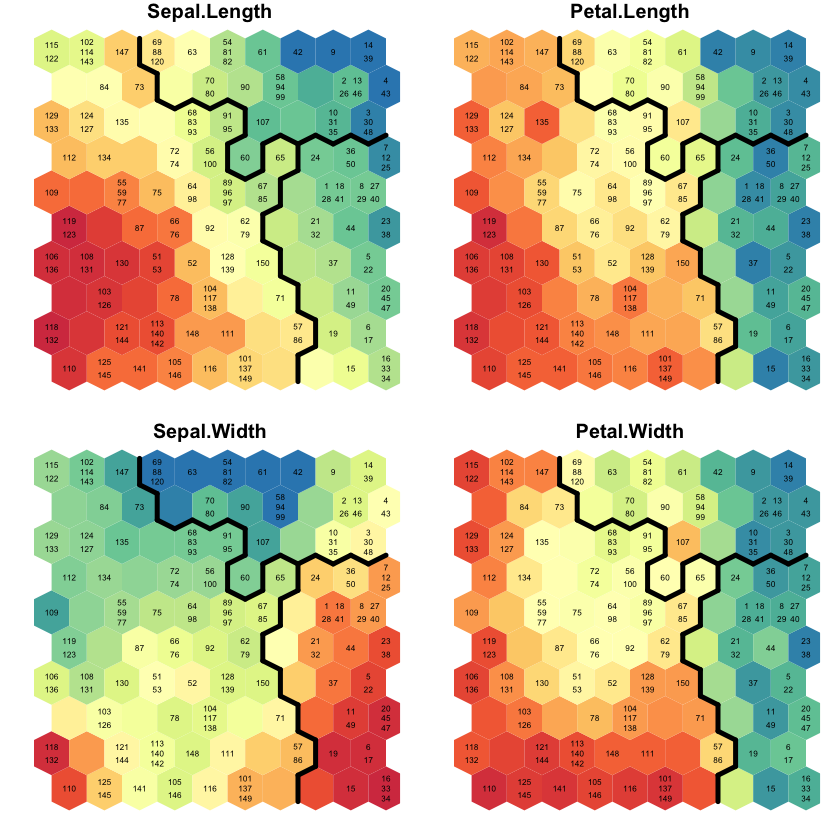

In [47]:
# VISUALIZE RESULTS COMPONENT PLANES
# ideally the sample distribution is relatively uniform
par(mar = rep(1, 4))
cplanelay <- layout(matrix(1:4, nrow=2))
vars <- colnames(data.som1$data[[1]])
for(p in vars) {
  plotCplane(som_obj=data.som1, variable=p, legend=FALSE, type="Quantile") # or "Quantile"
  add.cluster.boundaries(data.som1, som_cluster)
  add.numbers(data.som1, scale=0.5)
}

# for color bar probably:
#plot(0, 0, type = "n", axes = FALSE, xlim=c(0, 1), 
#     ylim=c(0, 1), xlab="", ylab= "")
#par(mar = c(0, 0, 0, 6))
#image.plot(legend.only=TRUE, col=rev(designer.colors(n=50, col=brewer.pal(9, "Spectral"))), zlim=c(-1.5,1.5))

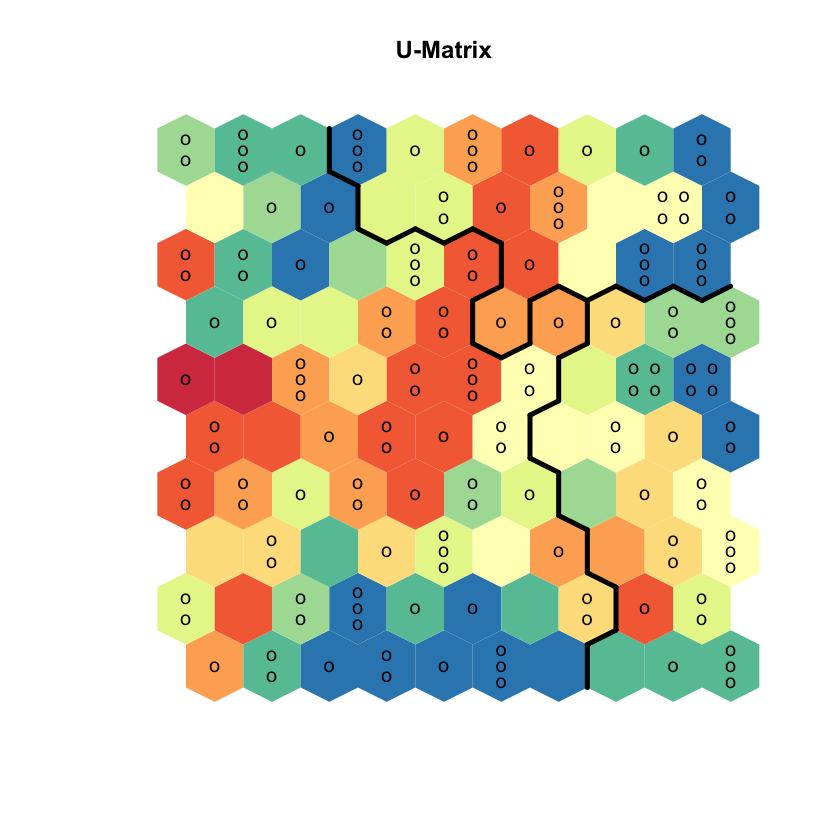

In [48]:
##PLOT U-MATRIX
plotUmat(data.som1, type = "Quantile") # type is Quantile or "Equal Interval"(default)
add.points(data.som1)
add.cluster.boundaries(data.som1, som_cluster)    